(notebook_name)=
# Chapter 3 The Beta-Binomial Bayesian Model
[Chapter 3 The Beta-Binomial Bayesian Model](https://www.bayesrulesbook.com/chapter-3.html)

:::{post} March 23, 2022
:tags: python
:category: beginner
:author: Lode Nachtergaele
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import wget
import requests
import pyreadr
import seaborn as sns
from scipy import stats
from scipy import integrate

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 1301
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# [Chapter 3 The Beta-Binomial Bayesian Model](https://www.bayesrulesbook.com/chapter-3.html)

## [3.1.2 Tuning the Beta prior](https://www.bayesrulesbook.com/chapter-3.html#tuning-the-beta-prior)

In [3]:
def plot_beta(alpha, beta, mean=False, mode=False):
    θ = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(θ, alpha, beta)
    plt.plot(θ, p_theta_given_y, lw=4, color='k')
    plt.xlabel('$\pi$')
    plt.ylabel('$f(x)$');

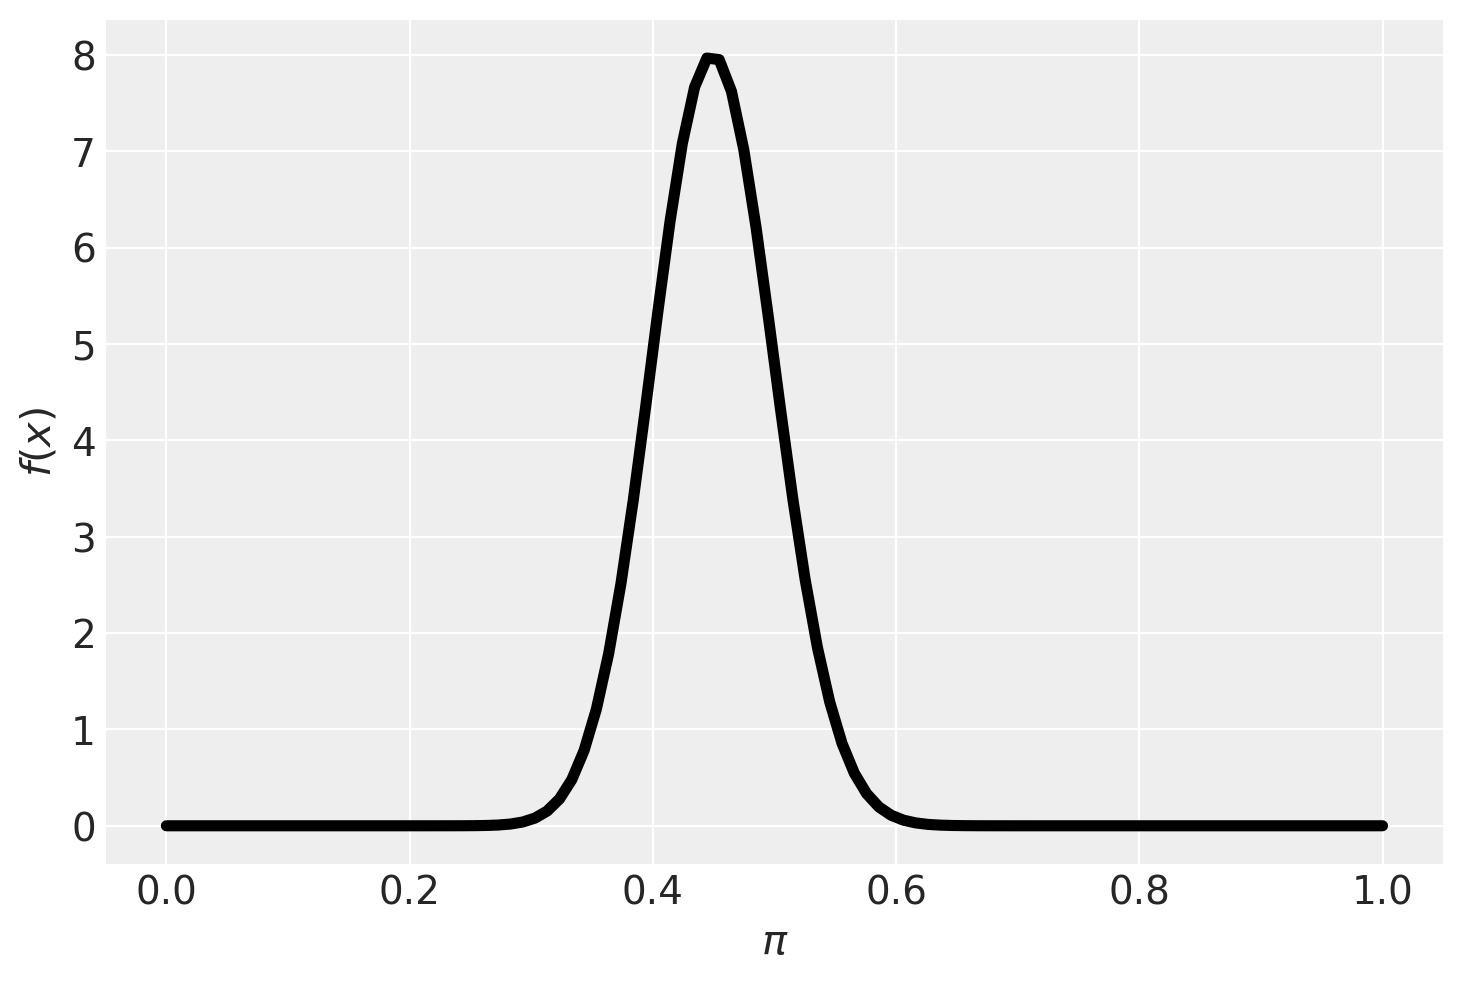

In [4]:
# Plot the Beta(45, 55) prior
plot_beta(45, 55)

In [49]:
def summarize_beta (alpha, beta):
    """ Summarize a Beta Model for \eqn{\pi}

    @param alpha,beta positive shape parameters of the Beta model

    Return Pandas Dataframe with summary
    """

    mean = alpha/(alpha+beta)
    var = alpha*beta / ((alpha + beta)**2  * (alpha + beta +1))
    sd = np.sqrt(var)

    if alpha < 1 and beta < 1:
        mode = "0 and 1"
    elif alpha <=1 and beta >1:
        mode = 0
    elif alpha > 1 and beta < 1:
        mode = 1
    else:
        mode = (alpha-1)/(alpha + beta -2)
    return pd.Series({'mean':mean, 'mode':mode, 'var':var, 'sd':sd})

In [50]:
summarize_beta(45, 55)


mean    0.450000
mode    0.448980
var     0.002450
sd      0.049502
dtype: float64

## [3.3 The Beta posterior model](https://www.bayesrulesbook.com/chapter-3.html#the-beta-posterior-model)

In [20]:
def plot_beta_binomial(alpha, beta,
    y=None, n=None, prior=True, likelihood=True, posterior=True):
    """Plot a Beta-Binomial Bayesian Model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y observed number of successes
    @param n observed number of trials
    @param prior a logical value indicating whether the prior model should be plotted
    @param likelihood a logical value indicating whether the scaled likelihood should be plotted
    @param posterior a logical value indicating whether posterior model should be plotted
    """

    if y is None or n is None:
        print('Warning: to visualize the posterior specify function parameters y and n')

    θ = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(θ, alpha, beta)
    # plt.plot(θ, p_theta_given_y, lw=4, color='k', label='prior')
    plt.fill_between(θ, p_theta_given_y, lw=4, color='k', label='prior', alpha=0.2)
    alpha_post = alpha + y
    beta_post = beta + n - y
    p_theta_given_y_post = stats.beta.pdf(θ, alpha_post, beta_post)
    # plt.plot(θ, p_theta_given_y_post, lw=4, color='r', label='posterior')
    plt.fill_between(θ, p_theta_given_y_post, lw=4, color='r', label='posterior', alpha=0.2)
    likelihood = stats.binom.pmf(y, n, θ)
    scale_factor = integrate.simpson(likelihood, θ)
    plt.fill_between(θ, likelihood/scale_factor, lw=4, color='b', label='likelihood scaled', alpha=0.2)
    plt.xlabel('$\pi$')
    plt.ylabel('density');
    plt.legend();

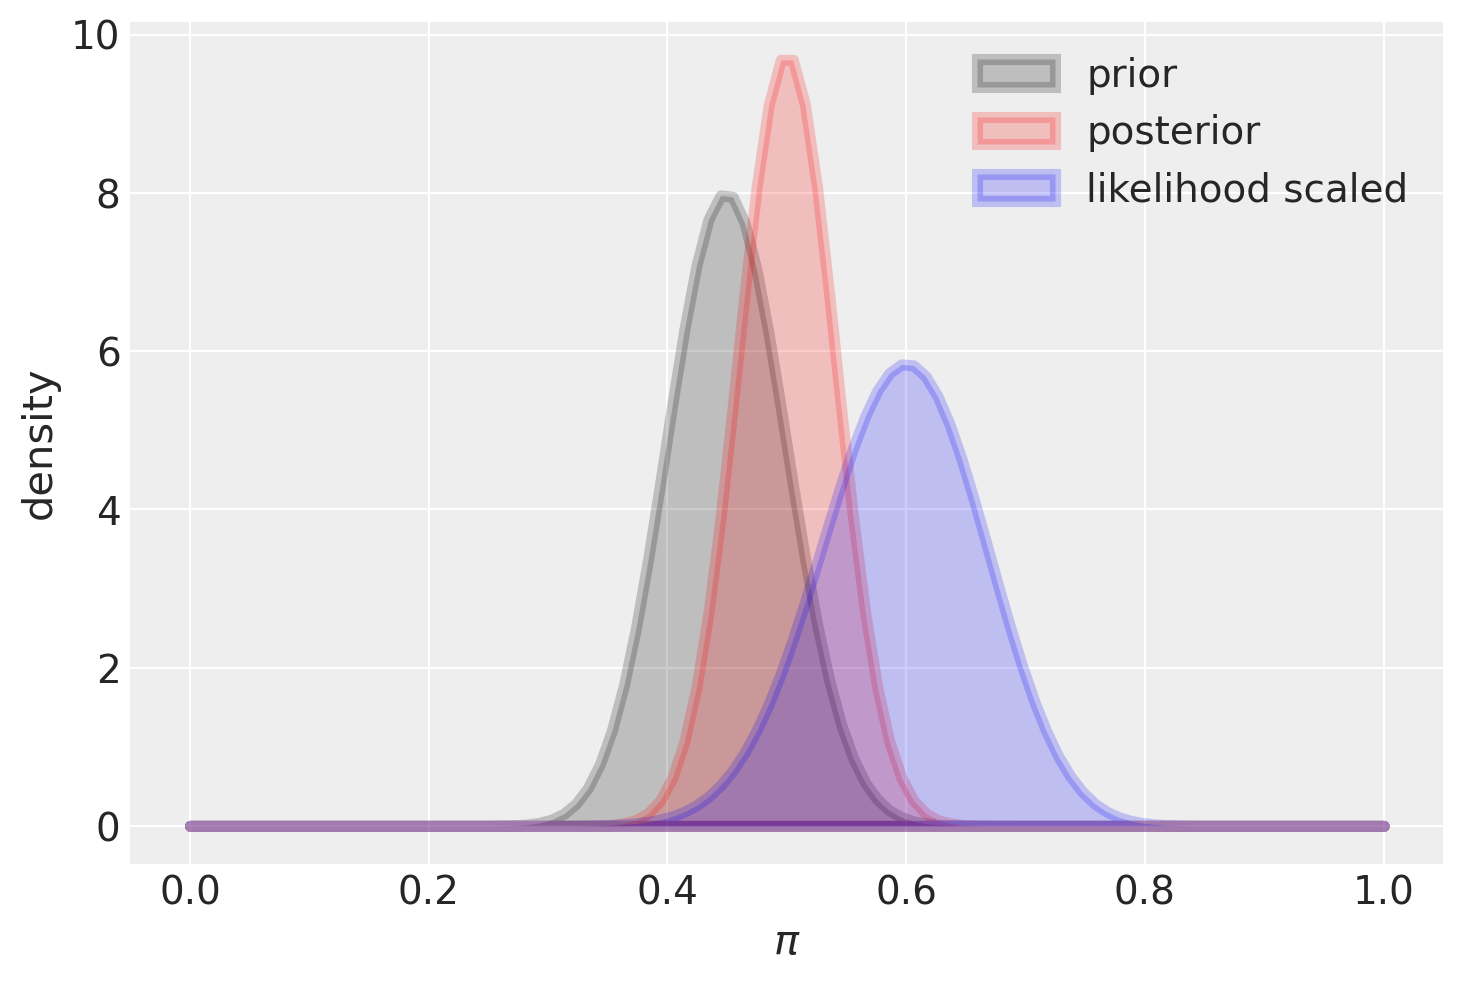

In [21]:
# FIGURE 3.7: The prior pdf, scaled likelihood function, and posterior pdf of Michelle’s election support π.
plot_beta_binomial(alpha = 45, beta = 55, y = 30, n = 50)

In [16]:
def summarize_beta_binomial(alpha, beta, y=None, n=None):
    """Summarize a Beta-Binomial Bayesian model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y number of successes
    @param n number of trials

    Return: Pandas dataframe summarizing beta binomial
    """
    def beta_mean(a, b):
        return a/(a+b)
    def beta_mode(a, b):
        if a < 1 and b < 1:
            return "0 and 1"
        elif a <= 1 and b > 1:
            return 0
        elif a > 1 and b < 1:
            return 1
        else:
            return (a-1)/(a+b-2)

    def beta_var(a, b):
        return a*b/((a + b)**2 * (a+b+1))

    prior_mean = beta_mean(alpha, beta)
    prior_mode = beta_mode(alpha, beta)
    prior_var = beta_var(alpha, beta)
    prior_sd = np.sqrt(prior_var)
    if y is None and n is None:
        summary = pd.DataFrame({'alpha':alpha, 'beta':beta, 
        'mean':prior_mean, 'mode':prior_mode, 'var':prior_var, 'sd':prior_sd}, index=['prior'])
    else:
        post_alpha = y + alpha
        post_beta = n - y + beta
        post_mean = beta_mean(post_alpha, post_beta)
        post_mode = beta_mode(post_alpha, post_beta)
        post_var = beta_var(post_alpha, post_beta)
        post_sd = np.sqrt(post_var)
        summary =  pd.DataFrame({'alpha':[alpha, post_alpha], 'beta':[beta, post_beta], 
        'mean':[prior_mean, post_mean], 'mode': [prior_mode, post_mode], 
        'var':[prior_var, post_var], 'sd':[prior_sd, post_sd]}, index=['prior', 'posterior'])
    return summary

In [17]:
summarize_beta_binomial(alpha = 45, beta = 55, y = 30, n = 50)

,alpha,beta,mean,mode,var,sd
prior,45,55,0.45,0.44898,0.002450,0.049502
posterior,75,75,0.50,0.50000,0.001656,0.040689


## [3.5 Simulating the Beta-Binomial](https://www.bayesrulesbook.com/chapter-3.html#chapter-3-simulation)

In [26]:
michelle_sim = pd.DataFrame({'pi': np.random.beta(a=45, b=55, size=10_000)})
michelle_sim['y'] = [np.random.binomial(n=50, p=pi) for pi in michelle_sim['pi']]
michelle_sim.head()

,pi,y
0,0.403782,18
1,0.498726,22
2,0.484765,26
3,0.464244,26
4,0.536034,25


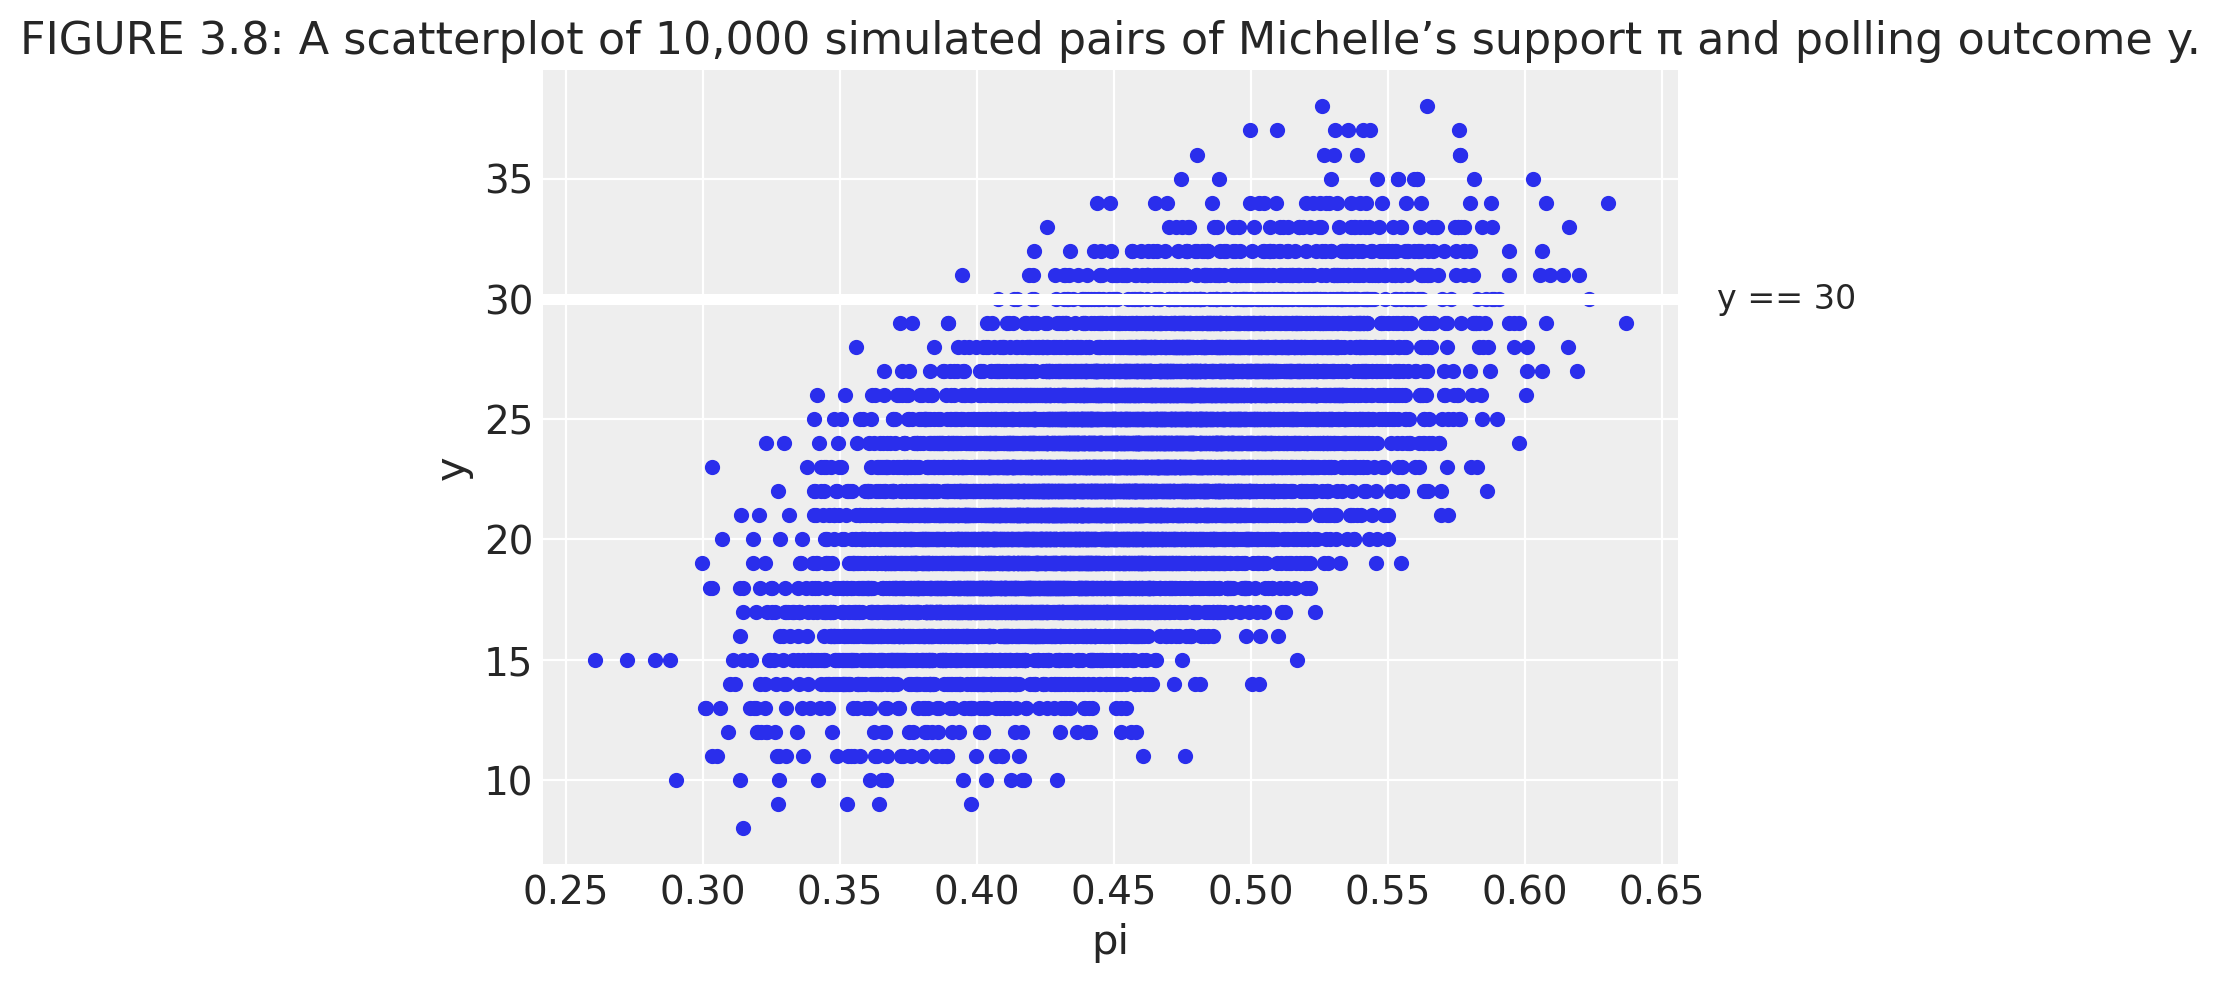

In [36]:
ax = michelle_sim.plot.scatter(x='pi', y='y');
ax.axhline(y=30, color='w', linewidth=4)
ax.text(0.67, 30, 'y == 30', fontsize=12, verticalalignment='center')
ax.set_title('FIGURE 3.8: A scatterplot of 10,000 simulated pairs of Michelle’s support π and polling outcome y.');

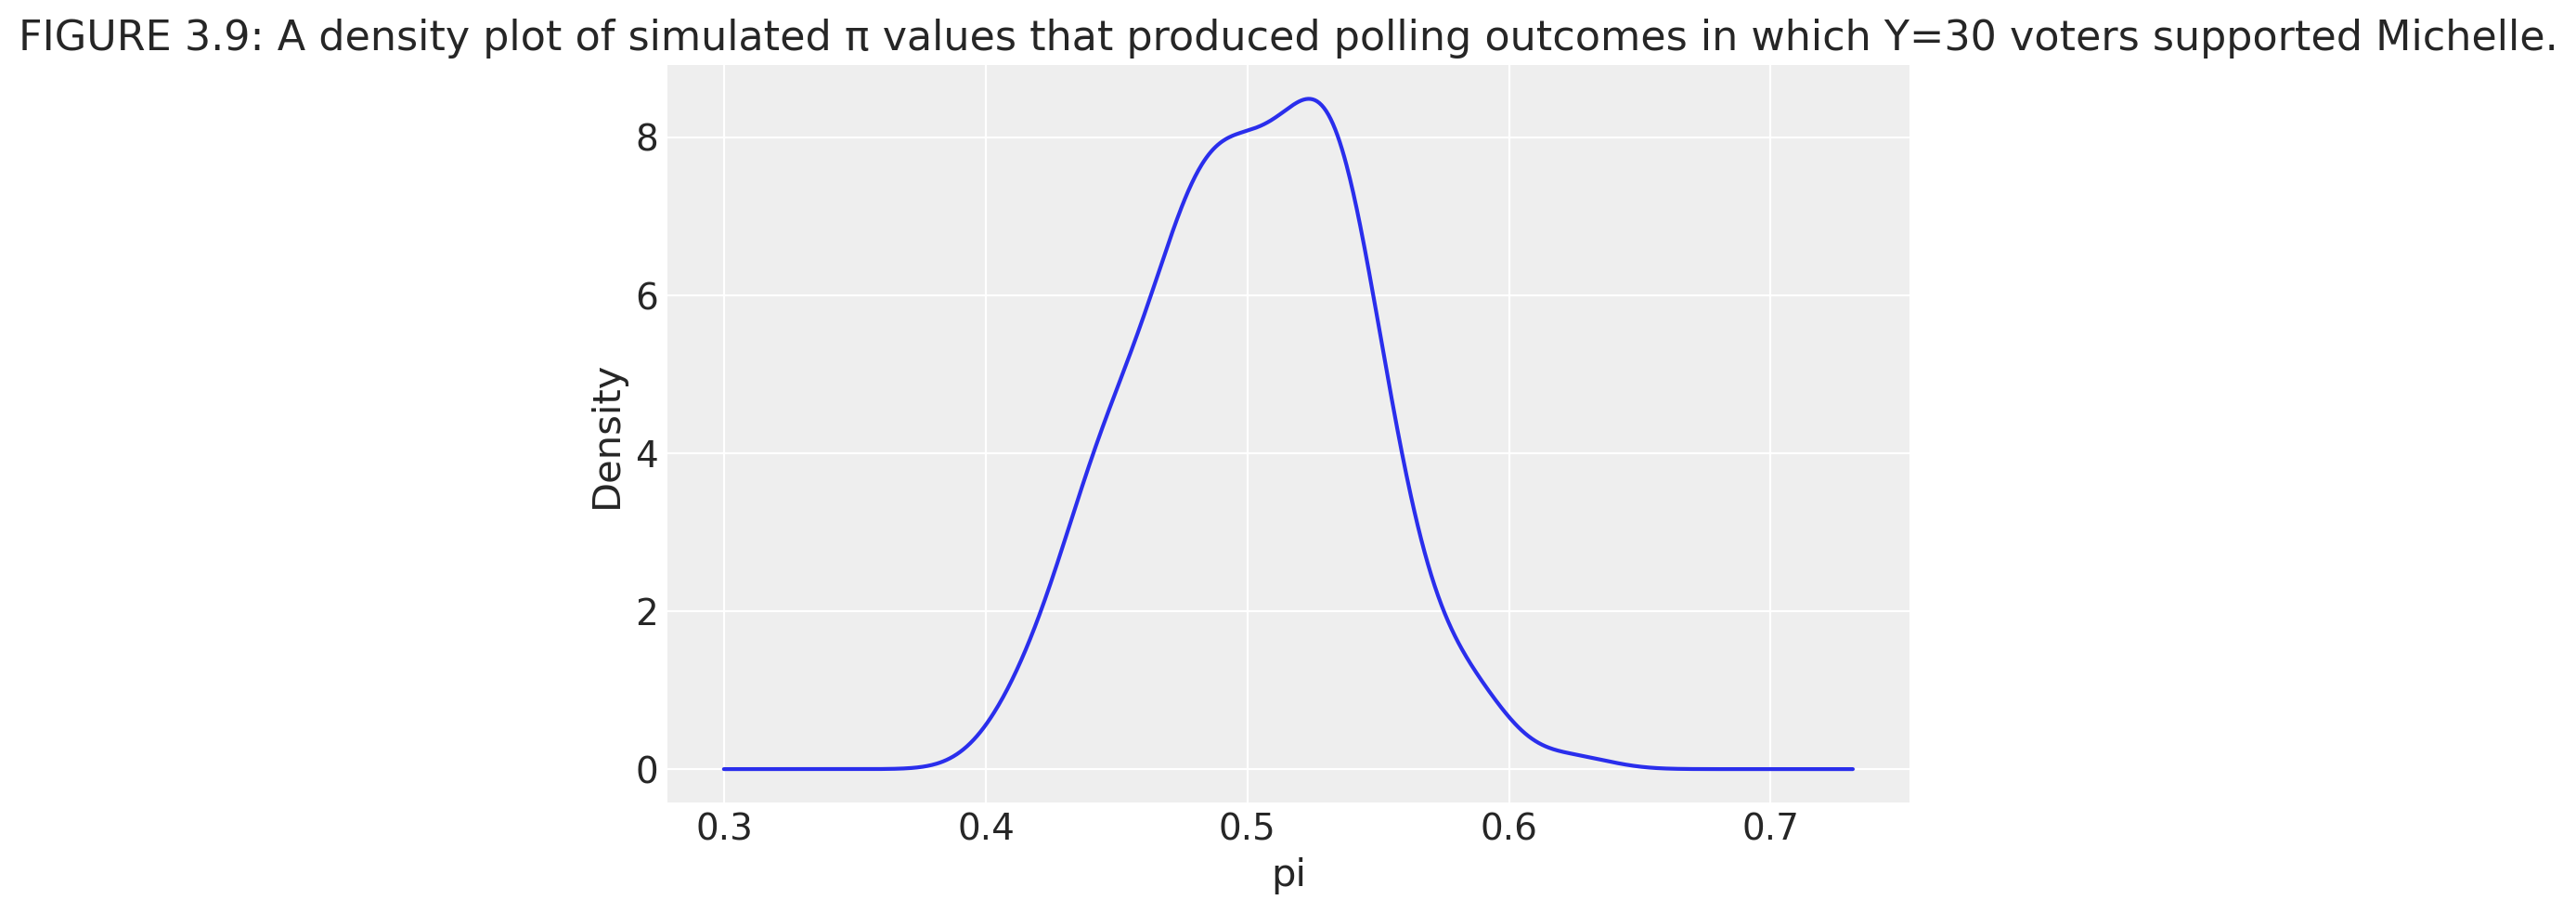

In [43]:
# Keep only the simulated pairs that match our data
michelle_posterior = michelle_sim.query('y == 30')
# Plot the remaining pi values
ax = michelle_posterior['pi'].plot.density();
ax.set_xlabel('pi');
ax.set_title('FIGURE 3.9: A density plot of simulated π values that produced polling outcomes in which Y=30 voters supported Michelle.');

In [45]:
michelle_posterior['pi'].describe()

count    172.000000
mean       0.502053
std        0.041346
min        0.407707
25%        0.472783
50%        0.502767
75%        0.532931
max        0.623532
Name: pi, dtype: float64

## [3.6 Example: Milgram’s behavioral study of obedience](https://www.bayesrulesbook.com/chapter-3.html#milgram-3)

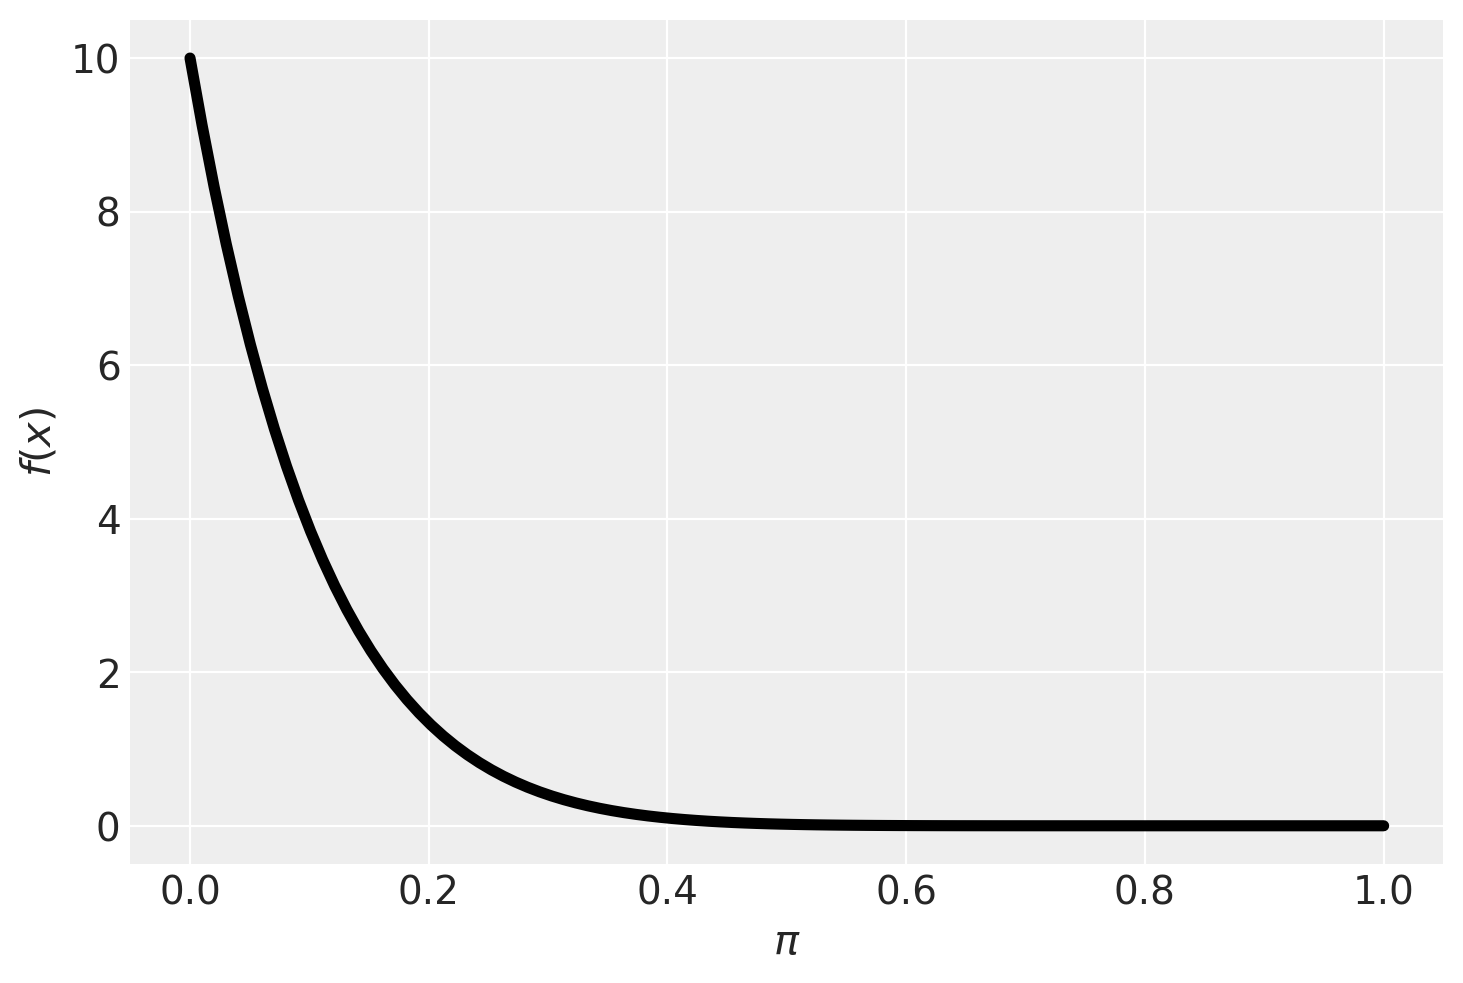

In [46]:
# Beta(1, 10) prior
plot_beta(alpha = 1, beta = 10)

In [47]:
summarize_beta_binomial(alpha = 1, beta = 10, y = 26, n = 40)

,alpha,beta,mean,mode,var,sd
prior,1,10,0.090909,0.000000,0.006887,0.082988
posterior,27,24,0.529412,0.530612,0.004791,0.069217


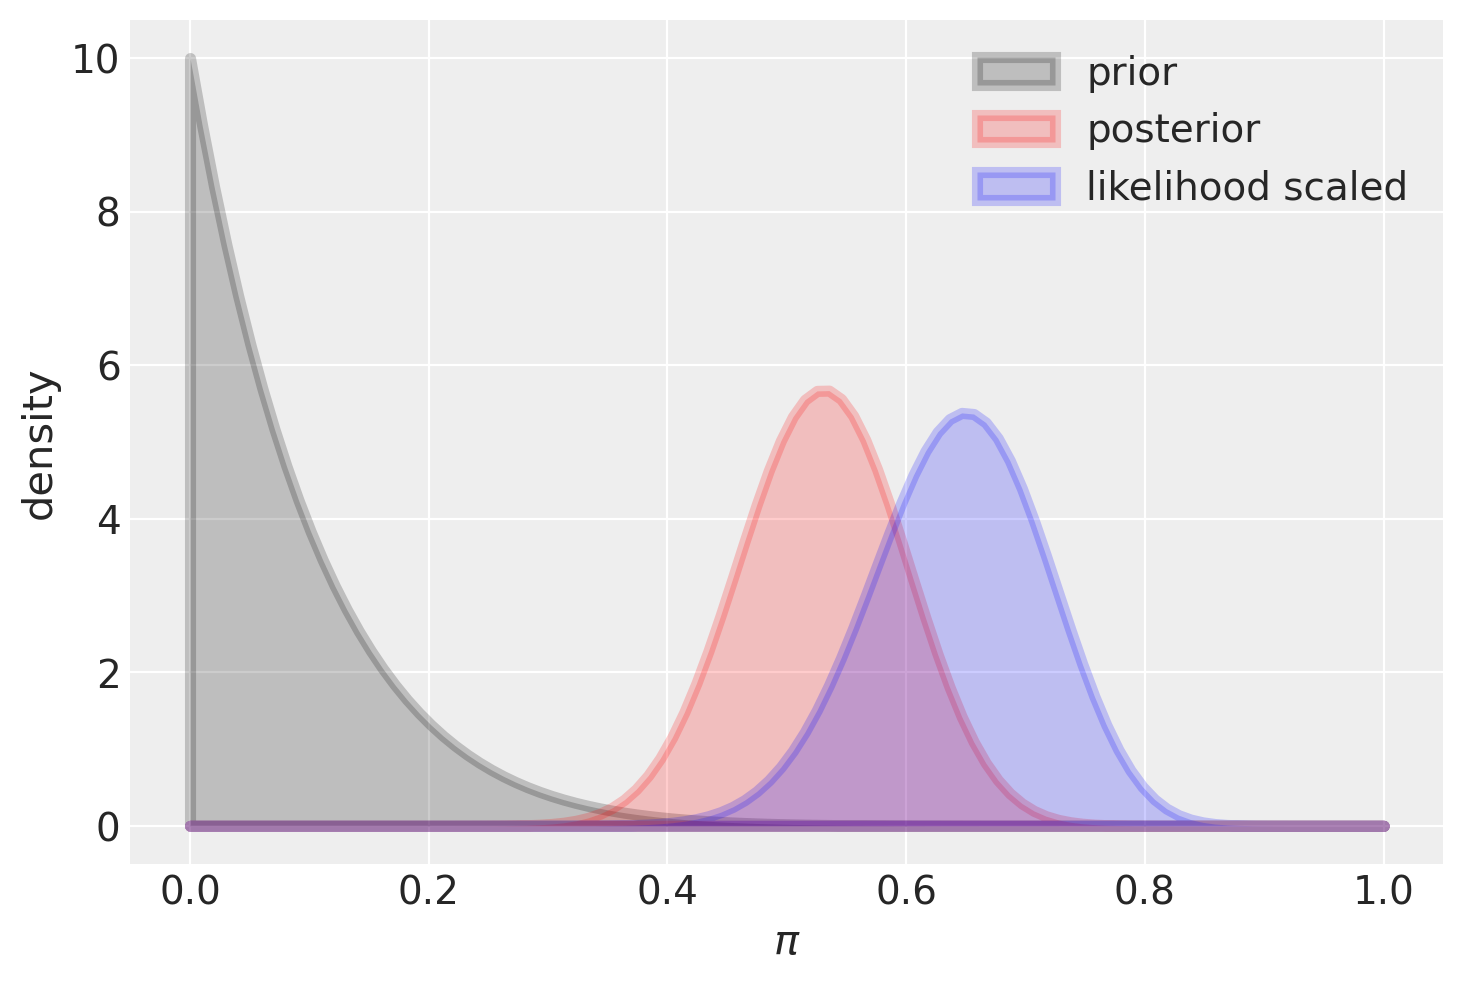

In [48]:

 # FIGURE 3.11: The Beta prior pdf, scaled Binomial likelihood function, and Beta posterior pdf for π,
 # the proportion of subjects that would follow the given instructions.
 plot_beta_binomial(alpha = 1, beta = 10, y = 26, n = 40)

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Mar 22 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.1.1

numpy     : 1.22.3
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:48) 
[Clang 11.1.0 ]
pandas    : 1.4.1
pyreadr   : 0.4.4
arviz     : 0.11.4
pymc3     : 3.11.4
matplotlib: 3.5.1
wget      : 3.2
seaborn   : 0.11.2
scipy     : 1.8.0

Watermark: 2.3.0



:::{include} ../page_footer.md
:::